In [1]:
import matplotlib.pyplot as plt
import gammapy
import numpy as np
import astropy
import regions
from pathlib import Path
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.maps import Map, MapAxis
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [2]:
#Directory where to find the DL3 data
basedir="/fefs/aswg/workspace/maria.bernardos/LSTanalysis/data_MC_comp/data/DL3/real/20210904/v0.7.3_test/tailcut84_hardcut/"

In [3]:
datastore = DataStore.from_dir(basedir)

In [4]:
#Run numbers to use in the analysis
obs_ids=[6039, 6040, 6041, 6042, 6043, 6044, 6045]
observations = datastore.get_observations(obs_ids)

No HDU found matching: OBS_ID = 6039, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 6040, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 6041, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 6042, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 6043, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 6044, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 6045, HDU_TYPE = psf, HDU_CLASS = None


In [5]:
#Define the ON region
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
on_region_radius = Angle("0.2 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [6]:
#Define a exclusion region to remove the closeby gamma-ray source RGB J0521+212
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)
skydir = target_position.galactic
exclusion_mask = Map.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)
mask = exclusion_mask.geom.region_mask([exclusion_region], inside=False)
exclusion_mask.data = mask

(<Figure size 432x288 with 1 Axes>,
 <WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>,
 None)

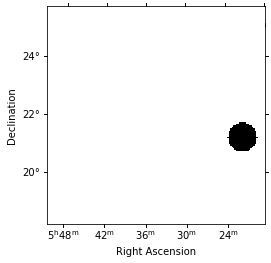

In [7]:
exclusion_mask.plot() #Plot the position of the exclusion mask

In [9]:
#Configuration of the maker classes

e_reco = MapAxis.from_energy_bounds(
    0.01, 10, 20, unit="TeV",
    name="energy")
e_true = MapAxis.from_energy_bounds(
    0.01, 100, 200, unit="TeV", name="energy_true"
)
dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, region=on_region
)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)

bkg_maker = ReflectedRegionsBackgroundMaker(max_region_number=1, min_distance_input="2 rad", exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

datasets = Datasets()

In [10]:
#We can define the range we want to use for the fitting
e_reco_max=2
e_fit_min=0.01 * u.TeV
e_fit_max=10 * u.TeV

In [11]:
#Build the on/off datasets
for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    
    #Mask for fitting only the specific range, comment to fit the full range
    mask_fit = Map.from_geom(geom=dataset_on_off.counts.geom, data = dataset_on_off.counts.geom.get_coord()["energy"] < 10**e_reco_max * u.TeV)
    dataset_on_off.counts.geom.energy_mask(energy_min=e_fit_min, energy_max=e_fit_max)
    dataset_on_off.mask_fit = mask_fit
    #=========================================
    
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

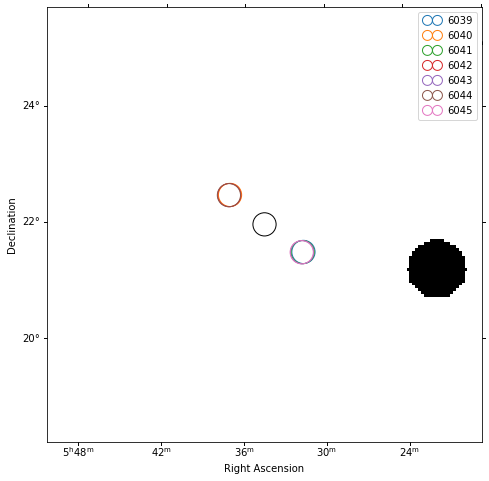

In [12]:

#Plot the ON and OFF regions
plt.figure(figsize=(8, 8))
_, ax, _ = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

In [15]:
#Print the information table

info_table = datasets.info_table(cumulative=True)
print(info_table)

name counts background excess ... counts_off acceptance acceptance_off alpha
                              ...                                           
---- ------ ---------- ------ ... ---------- ---------- -------------- -----
6039   84.0       60.0   24.0 ...       60.0       12.0           12.0   1.0
6039  240.0      158.0   82.0 ...      158.0       12.0           12.0   1.0
6039  467.0      275.0  192.0 ...      275.0       12.0           12.0   1.0
6039  767.0      403.0  364.0 ...      403.0       12.0           12.0   1.0
6039 1137.0      515.0  622.0 ...      515.0       12.0           12.0   1.0
6039 1547.0      641.0  906.0 ...      641.0       12.0           12.0   1.0
6039 1883.0      734.0 1149.0 ...      734.0       12.0           12.0   1.0


In [16]:
#Create a folder to save the results
path = Path(basedir+"/spectrum_analysis")
path.mkdir(exist_ok=True)

In [17]:
for dataset in datasets:
    dataset.to_ogip_files(outdir=path, overwrite=True)

In [18]:
#Define here a the spectral model as a log parabola for the Crab. Fo any other source you can use a power law

log_parabola = LogParabolaSpectralModel(
    alpha=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV", beta=0.1
)
model = SkyModel(spectral_model=log_parabola, name="crab")

for dataset in datasets:
    dataset.models = model

In [19]:
#Fit the spectral model to the data

fit_joint = Fit(datasets)
result_joint = fit_joint.run()

# we make a copy here to compare it later
model_best_joint = model.copy()

print(result_joint)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 148
	total stat : 307.80



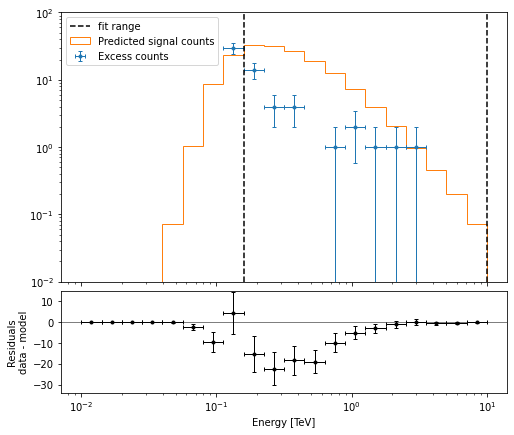

In [20]:
#Explore the residuals of the fitting
ax_spectrum, ax_residuals = datasets[0].plot_fit()
ax_spectrum.set_ylim(0.01, 100)
plt.show()

In [21]:
#Compute flux points
e_min, e_max = 0.01, 10
energy_edges = np.logspace(np.log10(e_min), np.log10(e_max), 21) * u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="crab")
flux_points = fpe.run(datasets=datasets)
plot_kwargs = {
    "energy_range": [0.05, 10] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

/home/maria.bernardos/miniconda3/envs/lst-dev/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:667: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/maria.bernardos/miniconda3/envs/lst-dev/lib/python3.7/site-packages/gammapy/estimators/flux_point.py:668: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/home/maria.bernardos/miniconda3/envs/lst-dev/lib/python3.7/site-packages/gammapy/modeling/models/spectral.py:405: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("lo

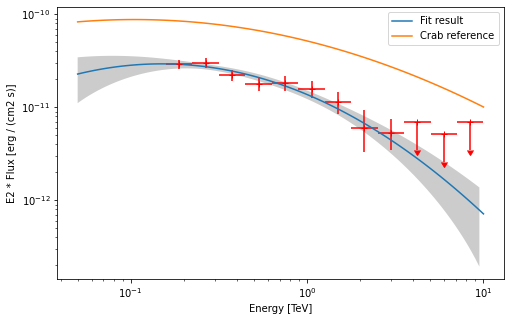

In [23]:
# plot joint model

plt.figure(figsize=(8, 5))

flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="red"
)

model_best_joint.spectral_model.plot(
    **plot_kwargs, label="Fit result", ls="-"
)
model_best_joint.spectral_model.plot_error(**plot_kwargs)

create_crab_spectral_model("magic_lp").plot(
    **plot_kwargs, label="Crab reference"
)
plt.legend()


In [25]:
#Other approach: Stacking the observatiosn first and then fitting the model

dataset_stacked = Datasets(datasets).stack_reduce()

dataset_stacked.models = model
stacked_fit = Fit([dataset_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model.copy()

print(result_stacked)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 81
	total stat : 7.99



/home/maria.bernardos/miniconda3/envs/lst-dev/lib/python3.7/site-packages/gammapy/modeling/models/spectral.py:405: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/maria.bernardos/miniconda3/envs/lst-dev/lib/python3.7/site-packages/gammapy/modeling/models/spectral.py:406: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/home/maria.bernardos/miniconda3/envs/lst-dev/lib/python3.7/site-packages/gammapy/modeling/models/spectral.py:405: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xsca

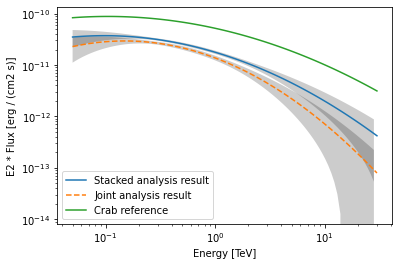

In [26]:
model_best_joint.parameters.to_table()

model_best_stacked.parameters.to_table()

plot_kwargs = {
    "energy_range": [0.05, 30] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

# plot stacked model
model_best_stacked.spectral_model.plot(
    **plot_kwargs, label="Stacked analysis result"
)
model_best_stacked.spectral_model.plot_error(**plot_kwargs)

# plot joint model
model_best_joint.spectral_model.plot(
    **plot_kwargs, label="Joint analysis result", ls="--"
)
model_best_joint.spectral_model.plot_error(**plot_kwargs)

create_crab_spectral_model("magic_lp").plot(
    **plot_kwargs, label="Crab reference"
)
plt.legend()